Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- SMSSpamCollection Dataset Overview ---
Shape: (5572, 2)
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

--- Enron Dataset Overview ---
Shape: (33716, 5)
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production 

<ipython-input-2-032fe1eaf1d0>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=label_column, palette='viridis')


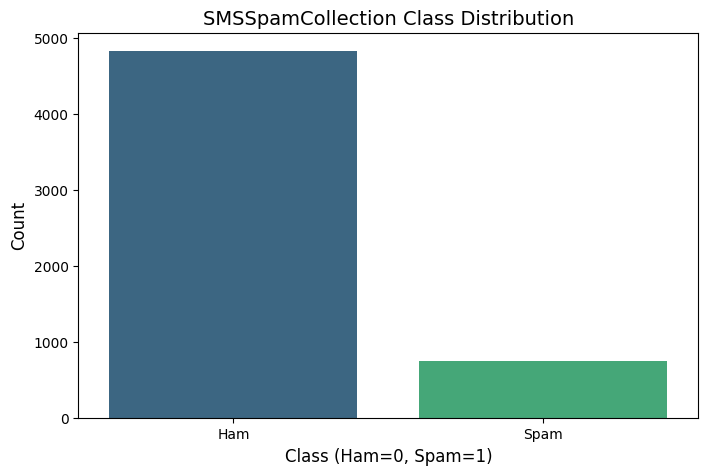

<ipython-input-2-032fe1eaf1d0>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=label_column, palette='viridis')


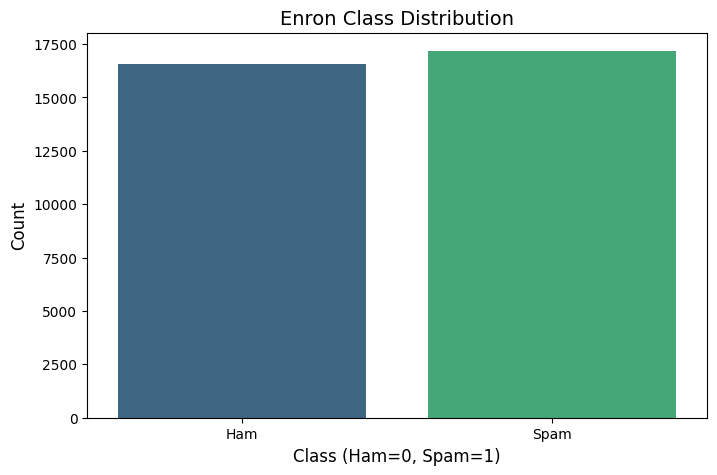

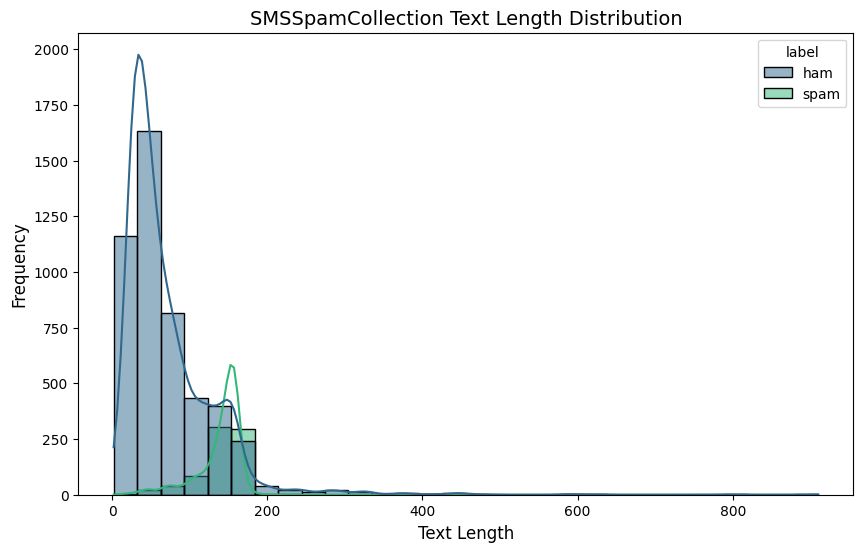

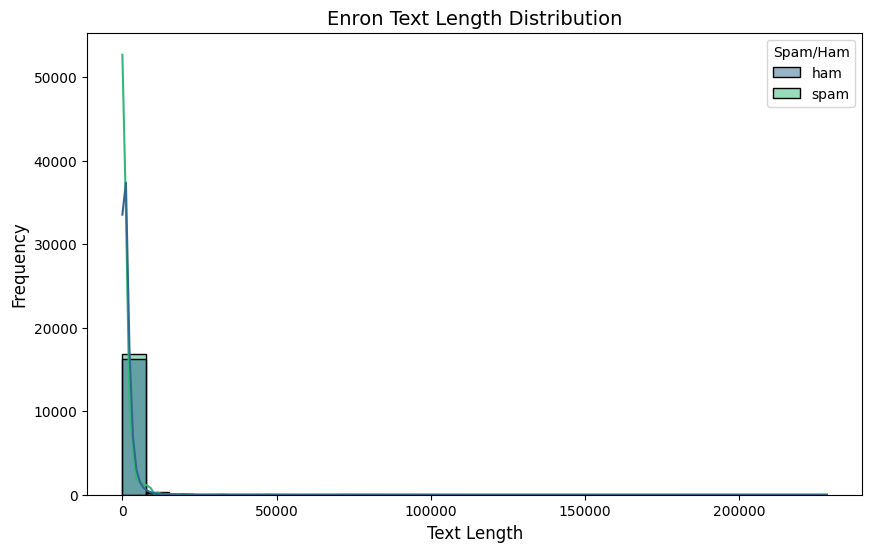

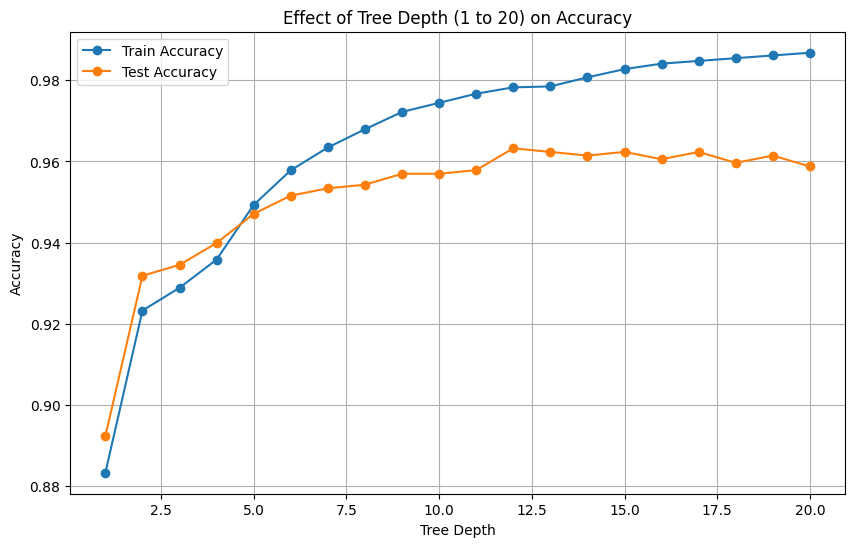

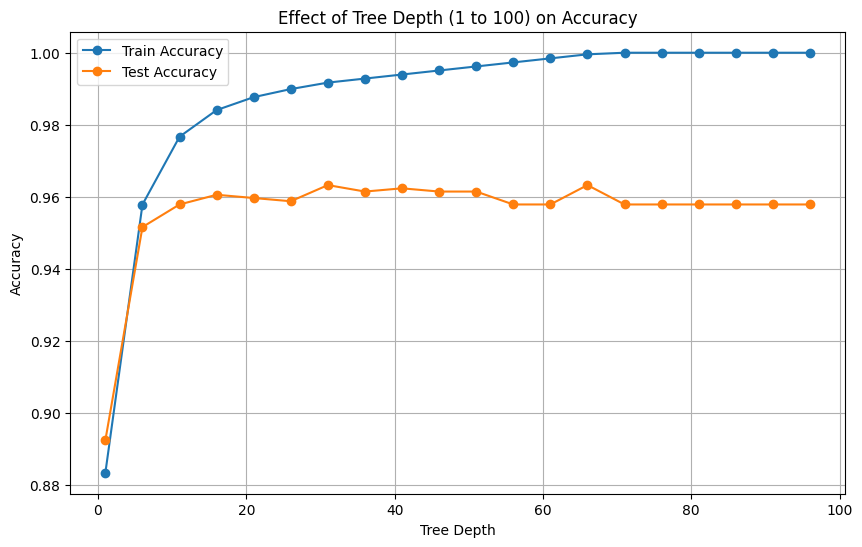


Best Decision Tree Parameters: {'max_depth': 20, 'min_samples_split': 2}

Decision Tree Performance:
SMSSpamCollection Dataset Accuracy: 0.9587443946188341
Enron Dataset Accuracy: 0.5159568157551311

--- Confusion Matrix (Decision Tree - SMSSpamCollection) ---


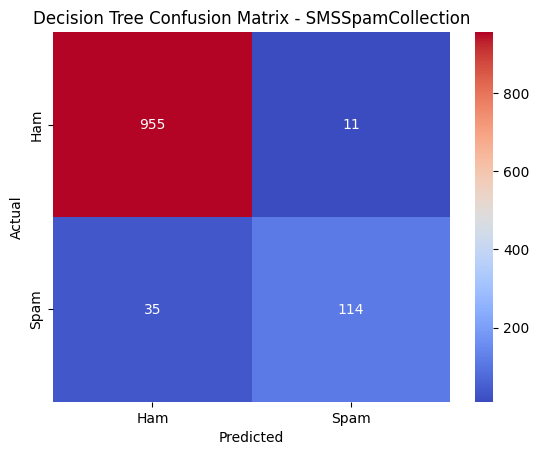


--- Confusion Matrix (Decision Tree - Enron) ---


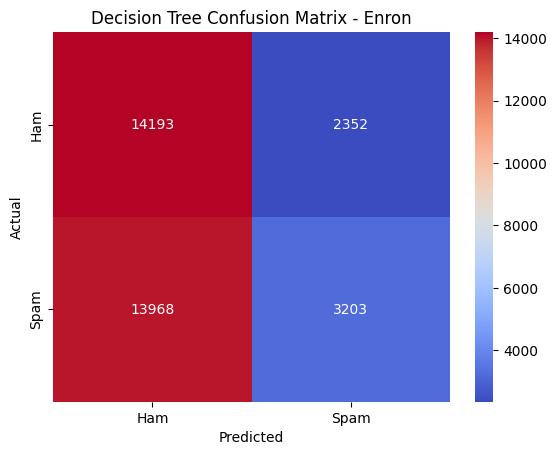


Logistic Regression Performance:
SMSSpamCollection Dataset Accuracy: 0.9596412556053812
Enron Dataset Accuracy: 0.49985170245580735

--- Confusion Matrix (Logistic Regression - SMSSpamCollection) ---


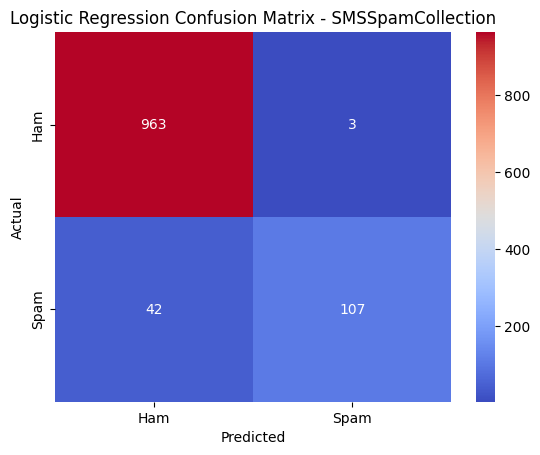


--- Confusion Matrix (Logistic Regression - Enron) ---


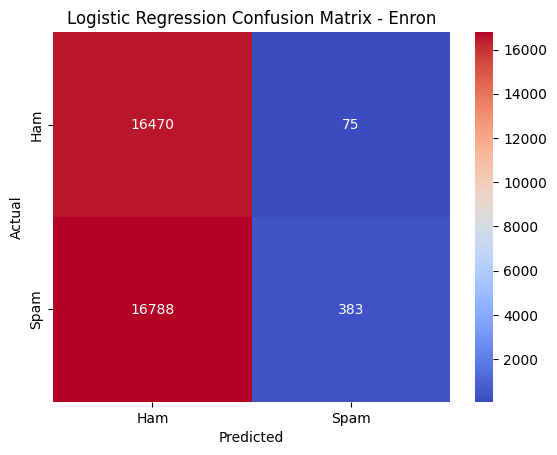

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

# Ensure necessary libraries are installed
!pip install nltk

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing punkt_tab data package

# Load datasets
# Ensure the correct path to your files in Google Drive
smsspam_path = '/content/drive/MyDrive/dataset/SMSSpamCollection'
enron_path = '/content/drive/MyDrive/dataset/enron_spam_data.csv'

smsspam_data = pd.read_csv(smsspam_path, sep='\t', header=None, names=['label', 'text'])
enron_data = pd.read_csv(enron_path)

# 1. Dataset Overview
# --- Overview of SMSSpamCollection Dataset ---
print("\n--- SMSSpamCollection Dataset Overview ---")
print(f"Shape: {smsspam_data.shape}")
print(smsspam_data.head())
print("\nClass Distribution:")
print(smsspam_data['label'].value_counts())

# --- Overview of Enron Dataset ---
print("\n--- Enron Dataset Overview ---")
print(f"Shape: {enron_data.shape}")
print(enron_data.head())
print("\nClass Distribution:")
print(enron_data['Spam/Ham'].value_counts())

# Plot class distribution for both datasets
def plot_class_distribution(data, label_column, title):
    """
    Function to plot the class distribution (spam vs. ham).
    """
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=label_column, palette='viridis')
    plt.title(title, fontsize=14)
    plt.xlabel('Class (Ham=0, Spam=1)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks([0, 1], ['Ham', 'Spam'])
    plt.show()

plot_class_distribution(smsspam_data, 'label', "SMSSpamCollection Class Distribution")
plot_class_distribution(enron_data, 'Spam/Ham', "Enron Class Distribution")

# Add text length column to both datasets for analysis
smsspam_data['text_length'] = smsspam_data['text'].apply(len)
enron_data['text_length'] = enron_data['Message'].astype(str).apply(len)

# Visualize text length distribution
def plot_text_length_distribution(data, length_column, label_column, title):
    """
    Function to plot text length distribution for spam and ham messages.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x=length_column, hue=label_column, bins=30, palette='viridis', kde=True)
    plt.title(title, fontsize=14)
    plt.xlabel('Text Length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

plot_text_length_distribution(smsspam_data, 'text_length', 'label', "SMSSpamCollection Text Length Distribution")
plot_text_length_distribution(enron_data, 'text_length', 'Spam/Ham', "Enron Text Length Distribution")

# Preprocessing function to clean text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Function to preprocess text:
    1. Convert to lowercase.
    2. Remove punctuation.
    3. Tokenize and remove stopwords.
    """
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to both datasets
smsspam_data['processed_text'] = smsspam_data['text'].apply(preprocess_text)
smsspam_data['label'] = smsspam_data['label'].map({'spam': 1, 'ham': 0})

enron_data['processed_text'] = enron_data['Message'].astype(str).apply(preprocess_text)
enron_data['label'] = enron_data['Spam/Ham'].map({'spam': 1, 'ham': 0})

# TF-IDF Vectorization (Feature Extraction)
vectorizer = TfidfVectorizer(max_features=5000)

# Transform SMSSpamCollection dataset
X_smsspam = vectorizer.fit_transform(smsspam_data['processed_text'])
y_smsspam = smsspam_data['label']

# Transform Enron dataset
X_enron = vectorizer.transform(enron_data['processed_text'])
y_enron = enron_data['label']

# Split SMSSpamCollection data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smsspam, y_smsspam, test_size=0.2, random_state=42)

# Effect of Tree Depth (1 to 20)
depths_1_to_20 = list(range(1, 21))
train_accuracies = []
test_accuracies = []

for depth in depths_1_to_20:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plot Effect of Tree Depth (1 to 20)
plt.figure(figsize=(10, 6))
plt.plot(depths_1_to_20, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(depths_1_to_20, test_accuracies, label="Test Accuracy", marker='o')
plt.title("Effect of Tree Depth (1 to 20) on Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Continue visualizations for tree depths from (1 to 100)
# Effect of Tree Depth (1 to 100)
depths_1_to_100 = list(range(1, 101, 5))
train_accuracies_100 = []
test_accuracies_100 = []

for depth in depths_1_to_100:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies_100.append(model.score(X_train, y_train))
    test_accuracies_100.append(model.score(X_test, y_test))

# Plot Effect of Tree Depth (1 to 100)
plt.figure(figsize=(10, 6))
plt.plot(depths_1_to_100, train_accuracies_100, label="Train Accuracy", marker='o')
plt.plot(depths_1_to_100, test_accuracies_100, label="Test Accuracy", marker='o')
plt.title("Effect of Tree Depth (1 to 100) on Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Decision Tree Classifier with Best Depth (GridSearchCV)
param_grid = {'max_depth': [5, 10, 15, 20, 50, None], 'min_samples_split': [2, 5, 10]}
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

print("\nBest Decision Tree Parameters:", clf.best_params_)

# Decision Tree Performance with Best Parameters
y_test_pred_tree = clf.predict(X_test)
y_enron_pred_tree = clf.predict(X_enron)

tree_smsspam_acc = accuracy_score(y_test, y_test_pred_tree)
tree_enron_acc = accuracy_score(y_enron, y_enron_pred_tree)

print("\nDecision Tree Performance:")
print(f"SMSSpamCollection Dataset Accuracy: {tree_smsspam_acc}")
print(f"Enron Dataset Accuracy: {tree_enron_acc}")

# Confusion Matrix for Decision Tree
print("\n--- Confusion Matrix (Decision Tree - SMSSpamCollection) ---")
conf_matrix_tree_smsspam = confusion_matrix(y_test, y_test_pred_tree)
sns.heatmap(conf_matrix_tree_smsspam, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Decision Tree Confusion Matrix - SMSSpamCollection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n--- Confusion Matrix (Decision Tree - Enron) ---")
conf_matrix_tree_enron = confusion_matrix(y_enron, y_enron_pred_tree)
sns.heatmap(conf_matrix_tree_enron, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Decision Tree Confusion Matrix - Enron')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression Model for Comparison
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train, y_train)

# Predictions
y_test_pred_log = log_model.predict(X_test)
y_enron_pred_log = log_model.predict(X_enron)

log_smsspam_acc = accuracy_score(y_test, y_test_pred_log)
log_enron_acc = accuracy_score(y_enron, y_enron_pred_log)

print("\nLogistic Regression Performance:")
print(f"SMSSpamCollection Dataset Accuracy: {log_smsspam_acc}")
print(f"Enron Dataset Accuracy: {log_enron_acc}")

# Confusion Matrix for Logistic Regression
print("\n--- Confusion Matrix (Logistic Regression - SMSSpamCollection) ---")
conf_matrix_log_smsspam = confusion_matrix(y_test, y_test_pred_log)
sns.heatmap(conf_matrix_log_smsspam, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Logistic Regression Confusion Matrix - SMSSpamCollection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n--- Confusion Matrix (Logistic Regression - Enron) ---")
conf_matrix_log_enron = confusion_matrix(y_enron, y_enron_pred_log)
sns.heatmap(conf_matrix_log_enron, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Logistic Regression Confusion Matrix - Enron')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
